<a href="https://colab.research.google.com/github/toufiqmusah/IndabaX25/blob/main/Neural%20Architecture%20Search%20%26%20Deployment%20Optimization%20Part-4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Efficient Deep Learning: Neural Architecture Search & Optimized Model Deployment** - Part 4

#### Program: `Deep Learning Indabax, Ghana, 2025` .
#### 🏫 Institution: Kumasu Centre for Collaborative Research in Tropical Medicine (KCCR)
#### 📅 Date: `*16 th June, 2025`

---

##### 👨‍🏫 Facilitator: Toufiq Musah       

**Lecturer and Researcher in Machine Learning**  

✉️ Email: [toufiq Musah](toufiqmusah32@gmail.com)  
🔗 LinkedIn: [toufiq](https://www.linkedin.com/in/toufiqmusah/)

---
### 🛠️ Tools and  Frameworks used  

- Python 3.x .
- TensorFlow 2.x / Keras
- Keras-Tuner for Parameterization
- Matplotlib / Seaborn for Visualization

---

# **Table of Contents**

1.   [Introduction](#Introduction)
2.   [Imports & Dataset](#Prerequisites)
3.   [Neural Architecture Search](#Prerequisites)
      - [NAS Model Building Function](#)
4.   [Post-Training Quantization](#Code-Examples)
5.   [Quantization-Aware Training](#Troubleshooting)
6.   [Conclusion](#Conclusion)
7.   [References](#References)

# 0. **Libraries, Imports & Data**

In [ ]:
!pip install -q keras-tuner tensorflow-model-optimization

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras

from sklearn.model_selection import train_test_split

tf.random.set_seed(42)

In [ ]:
# The Cancer Genome Atlas, Breast Cancer Dataset

!gdown -q '1odEM4UcDSnc_Yo8I6YeIa128d271k9q-'

In [ ]:
data = pd.read_csv('TCGA-BRCA-dataset.csv')
data.head()

,rs_CLEC3A,rs_CPB1,rs_SCGB2A2,rs_SCGB1D2,rs_TFF1,rs_MUCL1,rs_GSTM1,rs_PIP,rs_ADIPOQ,rs_ADH1B,...,pp_p27.pT198,pp_p38.MAPK,pp_p38.pT180.Y182,pp_p53,pp_p62.LCK.ligand,pp_p70S6K,pp_p70S6K.pT389,pp_p90RSK,pp_p90RSK.pT359.S363,vital.status
0,0.892818,6.580103,14.123672,10.606501,13.189237,6.649466,10.520335,10.338490,10.248379,10.229970,...,-0.043330,-0.002598,0.449228,-0.375230,-0.691766,-0.337863,-0.178503,0.011638,-0.207257,0
1,0.000000,3.691311,17.116090,15.517231,9.867616,9.691667,8.179522,7.911723,1.289598,1.818891,...,-0.220764,0.220809,1.035115,-0.074136,0.279067,0.292925,-0.155242,-0.089365,0.267530,0
2,3.748150,4.375255,9.658123,5.326983,12.109539,11.644307,10.517330,5.114925,11.975349,11.911437,...,0.010615,-0.133214,0.344969,-0.351936,0.219910,0.308110,-0.190794,-0.222150,-0.198518,0
3,0.000000,18.235519,18.535480,14.533584,14.078992,8.913760,10.557465,13.304434,8.205059,9.211476,...,0.064070,-0.384008,0.678042,0.096329,-0.266554,-0.079871,-0.463237,0.522998,-0.046902,0
4,0.000000,4.583724,15.711865,12.804521,8.881669,8.430028,12.964607,6.806517,4.294341,5.385714,...,-0.065488,0.209858,0.920408,0.042210,-0.441542,-0.152317,0.511386,-0.096482,0.037473,0


In [ ]:
data['vital.status'].unique()

array([0, 1])

In [ ]:
(x_train, x_test, y_train, y_test) = train_test_split(data.drop('vital.status', axis=1), data['vital.status'], test_size=0.2, random_state=42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((564, 1936), (564,), (141, 1936), (141,))

# 1. **Neural Architecture Search**

<div style="text-align: center;">
  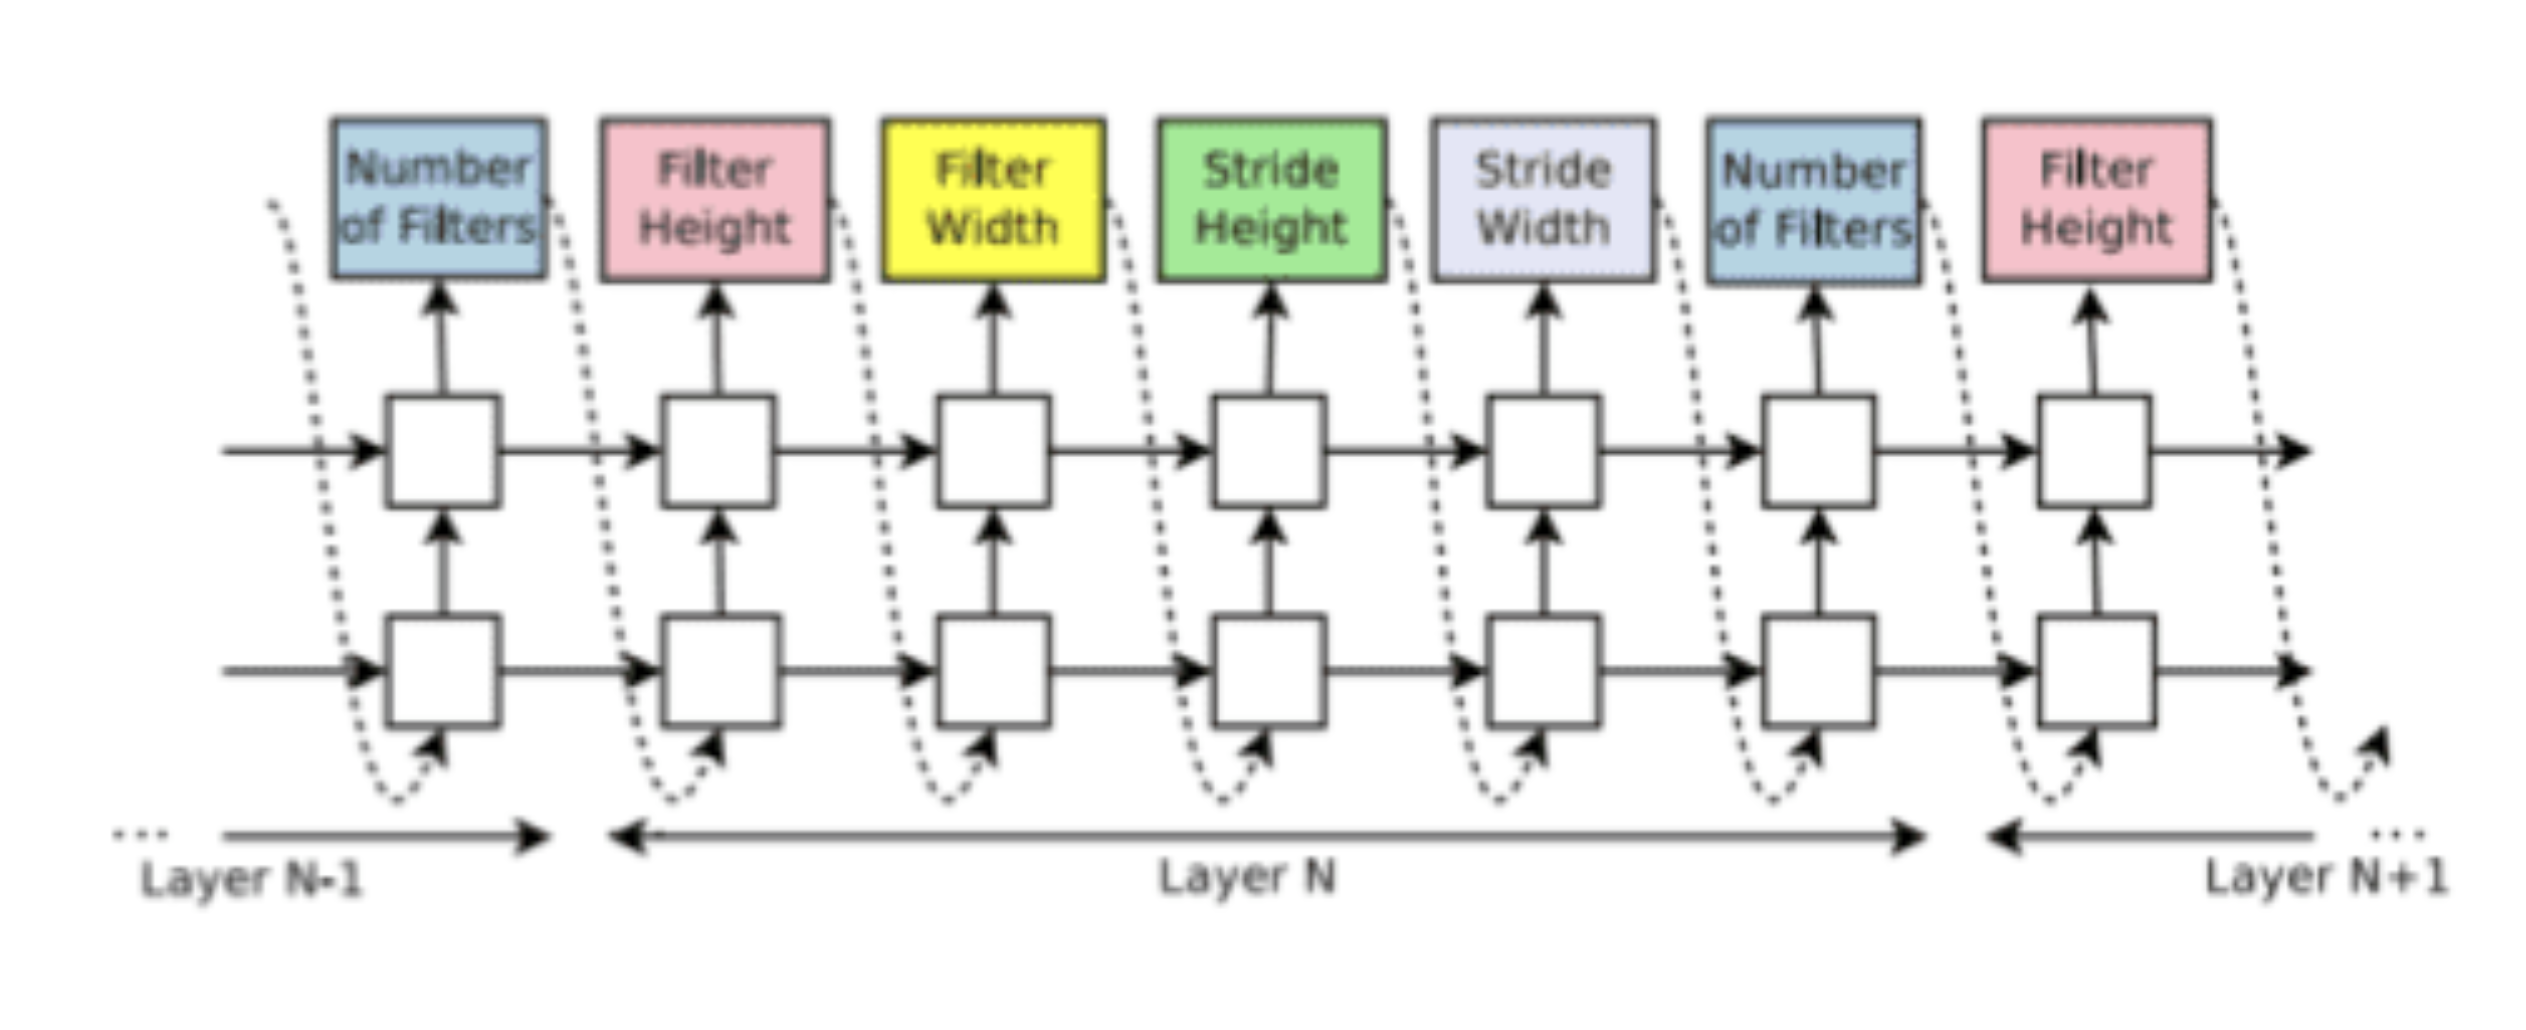
</div>


 *Why automate the design of the network itself?*

**Definition.** Neural Architecture Search (NAS) is an automated procedure that explores a *search space* of possible layer topologies and operations, trains many candidate networks, and selects the one that best optimises a user-defined objective (accuracy, latency, memory, …).

**How it differs from hyper-parameter optimisation.**  
NAS, in contrast to hyperparameterisation, can change the entire structure of a network (example; how many stages, which kernel size per block), instead of finetuning a given architecture.

---

#### **Example 1 – MnasNet: Reinforcement-Learning NAS**
Google’s **MnasNet** used a policy-gradient RL agent to sample entire mobile CNNs, training 8000 candidates and rewarding those with high ImageNet accuracy *and* low real-device latency.

#### **Example 2 – EfficientNet: NAS Baseline + Compound Scaling**
EfficientNet begins with **EfficientNet-B0**, *exactly* the architecture produced by MnasNet’s RL search. The authors then introduced a *compound scaling* rule to simultaneously widen, deepen, and increase input resolution, generating B1–B7 models that set new ImageNet efficiency records.

---
> **Take-away:** NAS automates decisions at the structural level—creating novel cells and macro layouts—whereas classical hyper-parameter search rather fine-tunes numeric settings inside a hand-crafted design.


### The Cancer Genomics Archive - Breast Cancer Omics Dataset
This is a **high dimensional** type of dataset, often requiring rigourous optimization techniques for the best of results.

### **NAS Model Building Function**

### Defining the Search Space

A compact **MobileNet‑style** search space:

| Hyper‑parameter | Choices |
|-----------------|---------|
| Number of Conv Blocks | 2 – 4 |
| Filters per Block     | 24 – 64 |
| Kernel Size           | 2, 3, or 5 |
| Depthwise Separable?  | {True, False} |
| Dropout Rate          | 0.0 – 0.3 |

In [ ]:
# model-building function that KerasTuner can use

def model_builder(hp):
    inputs = keras.Input(shape=(x_train.shape[1], 1))
    x = inputs
    num_blocks = hp.Int('num_blocks', 2, 4, 6)
    for i in range(num_blocks):
        filters = hp.Choice(f'filters_{i}', [24,32,40,48,64])
        kernel  = hp.Choice(f'kernel_{i}', [2,3,5])
        if hp.Boolean(f'ds_sep_{i}'):
            x = keras.layers.SeparableConv1D(filters, kernel,
                                                padding='same', activation='relu')(x)
        else:
            x = keras.layers.Conv1D(filters, kernel,
                                       padding='same', activation='relu')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.MaxPool1D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(rate=hp.Float('dropout',0.0,0.3,0.05))(x)
    outputs = keras.layers.Dense(2, activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    lr = hp.Choice('lr',[1e-3, 5e-4, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



# instantiating tuner

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=2,
                     factor=3,
                     directory='nas_dir',
                     overwrite=True,
                     project_name='intro_to_NAS')

### **NAS Training**

We will now be training various configurations to arrive at the best combination of model features.

In [ ]:
# adding early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# run NAS
print("Starting NAS search...")
tuner.search(x_train, y_train, epochs=2, validation_data=(x_test, y_test), callbacks=[stop_early])
print("NAS search complete.")

# optimal hyperparameters and the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
nas_model = tuner.hypermodel.build(best_hps)
print(f"Best hyperparameters: {best_hps.values}")

In [ ]:
# !rm -rf nas_dir

In [ ]:
# train best model found by NAS

print("Training the best model found by NAS...")
history = nas_model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f'Best epoch: {best_epoch}')

In [ ]:
# re-initialize the model and train up to the best epoch

hypermodel = tuner.hypermodel.build(best_hps)
print("Retraining the best model until the best epoch...")
hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_data=(x_test, y_test))
nas_best_model = hypermodel
print("Best model from NAS is trained and ready.")

# save model
nas_best_model.save("nas_optimal_model.keras")

In [ ]:
nas_best_model.summary()

# 2. **Post-training Quantization**

We will convert the SavedModel to **TFLite dynamic‑range INT8** and to **full‑integer INT8** with a *representative dataset*:

<p align="center">
  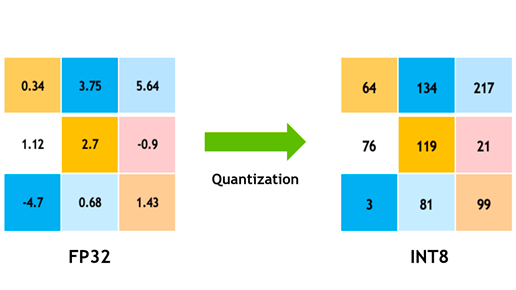
</p>


In [ ]:
# using a portion of the dataset

def representative_data_generator():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train.astype(np.float32)).batch(1).take(100):
    yield [tf.expand_dims(input_value, axis=-1)]

converter_int8 = tf.lite.TFLiteConverter.from_keras_model(nas_best_model)
converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]

converter_int8.representative_dataset = representative_data_generator

converter_int8.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8
]

In [ ]:
# create and save tensorflow-lite model

tflite_int8_quant_model = converter_int8.convert()
with open('nas_model_int8_quant.tflite', 'wb') as f:
    f.write(tflite_int8_quant_model)
print("Full INT8 quantized model saved as nas_model_int8_quant.tflite")

In [ ]:
# Let's compare the file sizes of the best NAS model, to the quantized model

NAS_MODEL_SIZE = os.path.getsize('nas_optimal_model.keras') / float(2**20)
QUANT_MODEL_SIZE = os.path.getsize('/content/nas_model_int8_quant.tflite') / float(2**20)

print(f"NAS Model Size:       {NAS_MODEL_SIZE: .3f} MB")
print(f"Quantized Model Size: {QUANT_MODEL_SIZE: .3f} MB")
print()

# checking compression efficiency
print(f"Size Efficiency:      {NAS_MODEL_SIZE/QUANT_MODEL_SIZE: .3f}")

# 3. **Quantization-Aware Training**
We use the **TensorFlow Model Optimization Toolkit** to fine‑tune a quantized‑simulation graph for **1–2 epochs**, then export a fully INT8 TFLite model.

---

We will have to rebuild our best Keras Model with `tfmot` compatible layers, and retrain to avert some dependency issues.

In [ ]:
from tensorflow_model_optimization.python.core.keras.compat import keras


def build_model(input_length: int = 1936, n_classes: int = 2):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_length,)),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(rate=0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(rate=0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(rate=0.2),

        keras.layers.Dense(n_classes, activation="softmax")
    ])
    return model

model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model = build_model()
model.summary()

In [ ]:
import tensorflow_model_optimization as tfmot

qat_model = tfmot.quantization.keras.quantize_model(model)
qat_model.compile(optimizer=keras.optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
qat_model.fit(x_train, y_train,
              batch_size=12,
              validation_data=(x_test, y_test),
              epochs=2)

In [ ]:
# Strip QAT nodes and convert
converter = tf.lite.TFLiteConverter.from_keras_model(qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_data_generator
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

In [ ]:
tflite_qat = converter.convert()
open('nas_qat_int8.tflite','wb').write(tflite_qat)

### **Why Quantize**

<p align="center">
  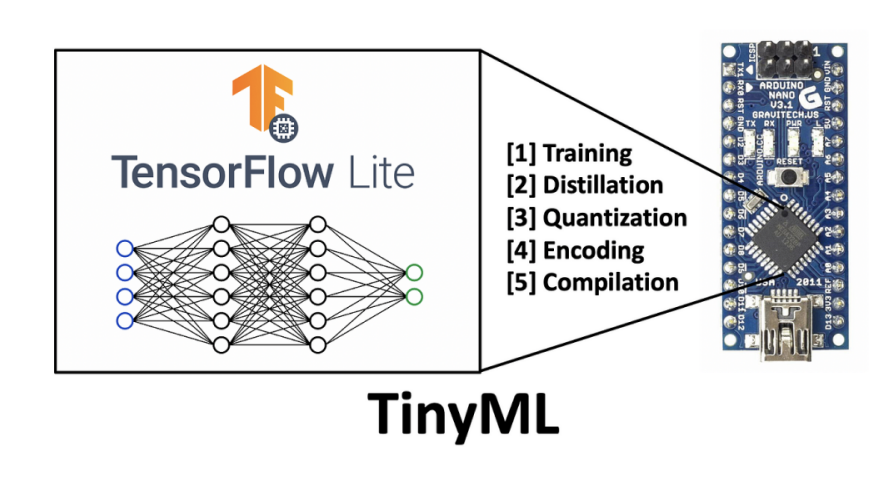
</p>


# ** References **

1. https://theaisummer.com/neural-architecture-search/
2. https://www.tensorflow.org/model_optimization/guide/quantization/training_example